<a href="https://colab.research.google.com/github/Kaushalsurana/SIH_hackathon/blob/main/Xception_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from IPython.display import Javascript

def disable_colab_idle_timeout():
    js_code = '''
    function ClickConnect(){
        console.log("Working");
        document.querySelector("colab-toolbar-button#connect").click()
    }
    setInterval(ClickConnect,60000)
    '''
    display(Javascript(js_code))

disable_colab_idle_timeout()

<IPython.core.display.Javascript object>

In [ ]:
!pip install opendatasets
!pip install pandas
import opendatasets as od
import pandas

od.download("https://www.kaggle.com/datasets/ascanipek/skin-diseases")

100%|██████████| 6.18G/6.18G [01:11<00:00, 93.1MB/s]


In [3]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

# re-size all the images to this
IMAGE_SIZE = [224, 224]

In [4]:
train='/content/skin-diseases/kaggle/train'
test='/content/skin-diseases/kaggle/test'
val='/content/skin-diseases/kaggle/val'

In [18]:
from tensorflow.keras.applications.xception import Xception
ress = Xception(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

#for layer in ress.layers:
  #layer.trainable = False

In [19]:
folders = glob('/content/skin-diseases/kaggle/train/*')
len(folders)

6

In [20]:
 import tensorflow as tf
 # useful for getting number of classes

x = Flatten()(ress.output)
# x = Dense(1000, activation='relu')(x)
prediction = Dense(len(folders), activation='softmax')(x)

# create a model object
model = Model(inputs=ress.input, outputs=prediction)

# view the structure of the model
model.summary()

# tell the model what cost and optimization method to use
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.0007,momentum=0.9),
  loss='categorical_crossentropy',
  metrics=['accuracy']
)

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 111, 111, 32)         864       ['input_3[0][0]']             
                                                                                                  
 block1_conv1_bn (BatchNorm  (None, 111, 111, 32)         128       ['block1_conv1[0][0]']        
 alization)                                                                                       
                                                                                                  
 block1_conv1_act (Activati  (None, 111, 111, 32)         0         ['block1_conv1_bn[0][0]'

In [21]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

training_set = train_datagen.flow_from_directory('/content/skin-diseases/kaggle/train',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

test_set = test_datagen.flow_from_directory('/content/skin-diseases/kaggle/test',
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 30909 images belonging to 6 classes.
Found 3928 images belonging to 6 classes.


In [22]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=5, verbose=1, mode='auto', restore_best_weights=True)
model_checkpoint = ModelCheckpoint('skin_disease_model.h5', save_best_only=True)

In [23]:
r = model.fit_generator(
  training_set,
  validation_data=test_set,
  epochs=25,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set),callbacks=[early, model_checkpoint]
)

<ipython-input-23-34c8a7b80cb2>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  r = model.fit_generator(


Epoch 1/25
966/966 [==============================] - ETA: 0s - loss: 0.9121 - accuracy: 0.6507

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


966/966 [==============================] - 788s 796ms/step - loss: 0.9121 - accuracy: 0.6507 - val_loss: 0.7101 - val_accuracy: 0.7225
Epoch 2/25
966/966 [==============================] - 762s 789ms/step - loss: 0.6555 - accuracy: 0.7527 - val_loss: 0.5963 - val_accuracy: 0.7777
Epoch 3/25
966/966 [==============================] - 768s 795ms/step - loss: 0.5271 - accuracy: 0.8066 - val_loss: 0.5408 - val_accuracy: 0.8055
Epoch 4/25
966/966 [==============================] - 761s 787ms/step - loss: 0.4350 - accuracy: 0.8413 - val_loss: 0.4913 - val_accuracy: 0.8294
Epoch 5/25
966/966 [==============================] - 767s 793ms/step - loss: 0.3506 - accuracy: 0.8741 - val_loss: 0.4701 - val_accuracy: 0.8434
Epoch 6/25
966/966 [==============================] - 761s 788ms/step - loss: 0.2909 - accuracy: 0.8955 - val_loss: 0.4846 - val_accuracy: 0.8467
Epoch 7/25
966/966 [==============================] - 766s 792ms/step - loss: 0.2329 - accuracy: 0.9182 - val_loss: 0.4433 - val_accura

In [24]:
model.save('final_skin_disease_model.h5')

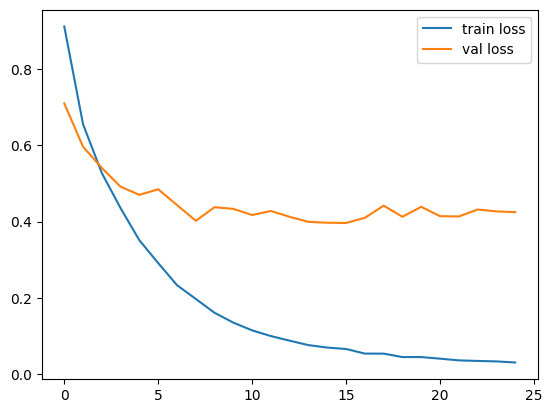

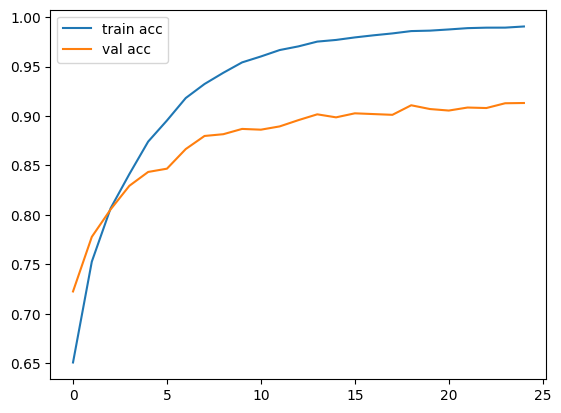

<Figure size 640x480 with 0 Axes>

In [25]:
import matplotlib.pyplot as plt

# plot the loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

1/1 [==============================] - 1s 778ms/step
[[0. 0. 1. 0. 0. 0.]]
Predicted Class Index: 2


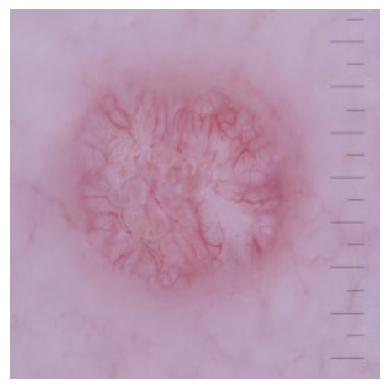

In [34]:
from tensorflow.keras.models import load_model

# Load the saved model
loaded_model = load_model('final_skin_disease_model.h5')

from keras.preprocessing import image
import numpy as np

# Load and preprocess the test image

test_image = image.load_img('/content/skin-diseases/kaggle/test/1. Enfeksiyonel/3_56.jpg', target_size=(224, 224))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis=0)

# Make predictions using the loaded model
predictions =loaded_model.predict(test_image)
print(predictions)
# Get the index of the predicted class
predicted_class_index = np.argmax(predictions)

# Print the predicted class index
print("Predicted Class Index:", predicted_class_index)
img = image.load_img('/content/skin-diseases/kaggle/test/1. Enfeksiyonel/3_56.jpg', target_size=(224, 224))
plt.imshow(img)
plt.axis('off')
plt.show()
